## Feature (Engineering) Regressions using ML/DL Algorithms

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys, os, time, math
import h5py 
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import pickle, subprocess
import umap, scipy, json 
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable

2024-08-27 13:26:23.305015: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 13:26:23.325556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 13:26:23.358036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 13:26:23.367843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 13:26:23.393226: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instru

In [2]:
from sklearn.datasets import make_classification, make_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, LassoCV, SGDRegressor
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [3]:
trajl = 1
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [4]:
fovs = ['A2_2']
nfovs = len(fovs)
pathSet = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/'
modelList = [None]*(nfovs)
modelList_conditions = np.zeros(nfovs).astype(int)

In [5]:
for i in range(nfovs):
    modelList_conditions[i] = i
    modelList[i] = f"{pathSet}{sysName}_{fovs[i]}"
    #print("Model Info: ",modelList[i])

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [6]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models, i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_2.obj with 97764 cells


In [7]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [8]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [9]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
for i in indgood_models:
    modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0

In [10]:
n_COMfeatures = 3
Xf_com0 = np.zeros((0, n_COMfeatures))
for i in indgood_models:
    Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [11]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])

for i in indgood_models:
    Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
    # Indices for each model for later access using them
    indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
    indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [12]:
for i in indgood_models:
    indsf = np.where(indtreatment == i)[0]
    modelSet[i].Xf = Xf[indsf, :]

In [13]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    print(f"Get single-cell trajectories of model: {i}")
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

Get single-cell trajectories of model: 0
tracked cell 97681, 99 tracks, 96000 left
tracked cell 97491, 26 tracks, 88600 left
tracked cell 97080, 1 tracks, 70500 left
tracked cell 97030, 1 tracks, 69600 left
tracked cell 96323, 1 tracks, 69200 left
tracked cell 95568, 1 tracks, 68800 left
tracked cell 94699, 1 tracks, 68200 left
tracked cell 94670, 3 tracks, 68100 left
tracked cell 94178, 1 tracks, 67300 left
tracked cell 92330, 2 tracks, 66100 left
tracked cell 92141, 5 tracks, 65900 left
tracked cell 92088, 1 tracks, 65800 left
tracked cell 91522, 1 tracks, 65600 left
tracked cell 90715, 1 tracks, 64800 left
tracked cell 89955, 19 tracks, 63900 left
tracked cell 88654, 1 tracks, 62700 left
tracked cell 88173, 2 tracks, 62600 left
tracked cell 87958, 1 tracks, 62400 left
tracked cell 87425, 36 tracks, 61900 left
tracked cell 86624, 1 tracks, 61200 left
tracked cell 86238, 1 tracks, 60900 left
tracked cell 83339, 1 tracks, 58900 left
tracked cell 83179, 1 tracks, 58800 left
tracked cell

## Load Cell Features & Labels Extracted from O2VAE (https://github.com/directysj/o2vae.git)

In [14]:
num_latent_dim=256
data_vae = np.load(f'../o2vae/features_vae{num_latent_dim}_LI204601_A2_2.npz')
features_vae = data_vae['embeddings']
labels_vae = data_vae['labels']

In [15]:
for i in indgood_models:
    indsf = np.where(indtreatment == i)[0]
    modelSet[i].Xf_vae = features_vae[indsf, :]

In [16]:
for i in indgood_models:
    cell2cell_interaction_features = modelSet[i].Xf[:, 77:]
    modelSet[i].Xf_new = np.concatenate((modelSet[i].Xf_vae, cell2cell_interaction_features), axis=1)

In [17]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

## Single-cell Trajectories Over The Cell Features

In [18]:
#Xf_traj = np.zeros((0, (modelSet[0].Xf.shape[1]+n_COMfeatures)*trajl))
#Xf_traj = np.zeros((0, (modelSet[0].Xf_new.shape[1]+n_COMfeatures)*trajl))
Xf_traj = np.zeros((0, modelSet[0].Xf_vae.shape[1]*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
for i in indgood_models:
    print(f'Building trajectory data for model: {i}')
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xf_vae[modelSet[i].traj, :] 
    #datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_vae.shape[1]*trajl)
    #datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    #data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xf_traj = np.append(Xf_traj, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    ind_frames = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame indices at the start of snippets
    ind_frames = ind_frames + trajl # Frame indices at the end of snippets
    indframes_traj = np.append(indframes_traj, ind_frames) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories

Building trajectory data for model: 0


In [19]:
# Get Cross correlations & respective frame numbers along all single-cell trajectories
def get_cross_corr_all_single_cell_trajs(filename):
      cross_corr_sctraj = []
      frame_num_sctraj = []
      with open(filename, 'r') as file_in:
          # Create an iterator over the file lines 
          file_iter = iter(file_in)
          try:
              while True:
                  # Read two lines at a time: Cross correlations & the corresponding frame numbers
                  line1 = next(file_iter).strip()
                  if line1:
                          data = ast.literal_eval(line1)
                          cross_corr_sctraj.append(data)
                          line2 = next(file_iter).strip()
                          # Parse line2 as a list of integers
                          frame_numbers = ast.literal_eval(line2)   
                          frame_num_sctraj.append(frame_numbers)
          except StopIteration:
              # End of file reached
              pass
      cross_corr_all_sctraj_file = cross_corr_sctraj
      frame_num_all_sctraj_file = frame_num_sctraj
      
      return cross_corr_all_sctraj_file, frame_num_all_sctraj_file

In [20]:
cc_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/new_cal_CCvalsScaleImgs/'

In [21]:
# Get cross-correlation values along all single-cell trajectories  
cc_filename = f"{cc_path}{sysName}_{fovs[0]}.dat_run1"
cross_correlations, frame_numbers = get_cross_corr_all_single_cell_trajs(cc_filename)

cc_values_last_frames = []
model_indc = 0
indstm = np.where(indtreatment_traj == model_indc)[0]
fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 
################## Identify the "FULL" trajectory index and locate snippets within it ##################
for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
    possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])  
    indc_ccvals_traj = possible_indices[0][0]
    #print(f'Indices of Entire Traj: {ind_fulltraj}, Indices of CC_traj: {indc_ccvals_traj}')
    cc_vals = cross_correlations[ind_fulltraj][indc_ccvals_traj]
    #print(f'CC values: {cc_vals}, Indices of Entire Traj: {ind_fulltraj}, Indices of CC trajectory: {indc_ccvals_traj}')
    cc_values_last_frames.append(cc_vals)
cc_values_last_frames = np.array(cc_values_last_frames)
X_traj_model = Xf_traj[indstm]
X = X_traj_model
y = cc_values_last_frames

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

<Figure size 640x480 with 0 Axes>

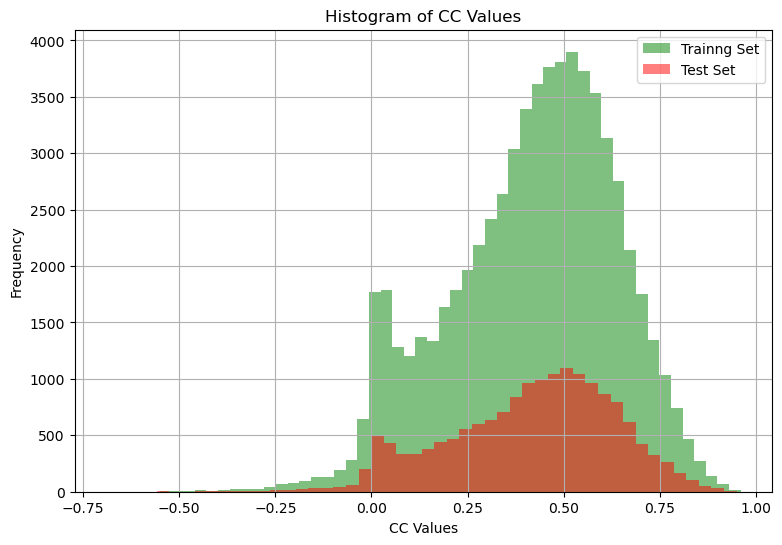

In [23]:
n_bins = 50
plt.clf()
plt.figure(figsize = (9, 6))
plt.hist(y_train, bins = n_bins, alpha = 0.5, color = 'g', label = 'Trainng Set')
plt.hist(y_test, bins = n_bins, alpha = 0.5, color='r', label = 'Test Set')
plt.xlabel('CC Values')
plt.ylabel('Frequency')
plt.title('Histogram of CC Values')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def trim_cc_vals(cc_values, num_bins, target_density):
    df = pd.DataFrame(cc_values, columns=['CC'])
    df['original_index'] = df.index # Include original indices in the DataFrame
    
    counts, bin_edges = np.histogram(df['CC'], bins=num_bins) # Calculate histogram without plotting
    df['bin'] = pd.cut(df['CC'], bins=bin_edges, labels=False, include_lowest=True) # Create a bin label based on the bin_edges

    trimmed_data = []
    
    for i in range(num_bins):
        bin_filter = (df['bin'] == i) # Filter the DataFrame to get data only in this bin
        bin_data = df[bin_filter]

        # If the number of items in the bin is greater than target_density, sample down
        if bin_data.shape[0] > target_density:
           sampled_data = bin_data.sample(n=target_density, random_state=42)
        else:
           sampled_data = bin_data
        trimmed_data.append(sampled_data) # Append the sampled or full bin data to the list
    
    trimmed_df = pd.concat(trimmed_data) # Concatenate all trimmed data back into a DataFrame
    trimmed_df = trimmed_df.sort_values('original_index') # Sorting by original index to preserve the original data order
    
    return trimmed_df

In [25]:
# scaler = StandardScaler() # Scale features with Zero Mean & Unit Variance
scaler = MinMaxScaler() # Scale features in the range [0, 1]

In [26]:
num_features = 75
pca = PCA(n_components = num_features)
Xpca = pca.fit_transform(X)

53 Non-Zero PCs/Features Selected by LassoCV: [  1   5  12  16  25  26  42  51  56  60  63  67  70  74  80  85  88  99
 105 107 110 118 119 122 125 129 131 132 136 137 142 159 160 163 166 172
 179 181 194 195 201 202 205 207 215 218 219 226 228 231 244 247 251]


<Figure size 640x480 with 0 Axes>

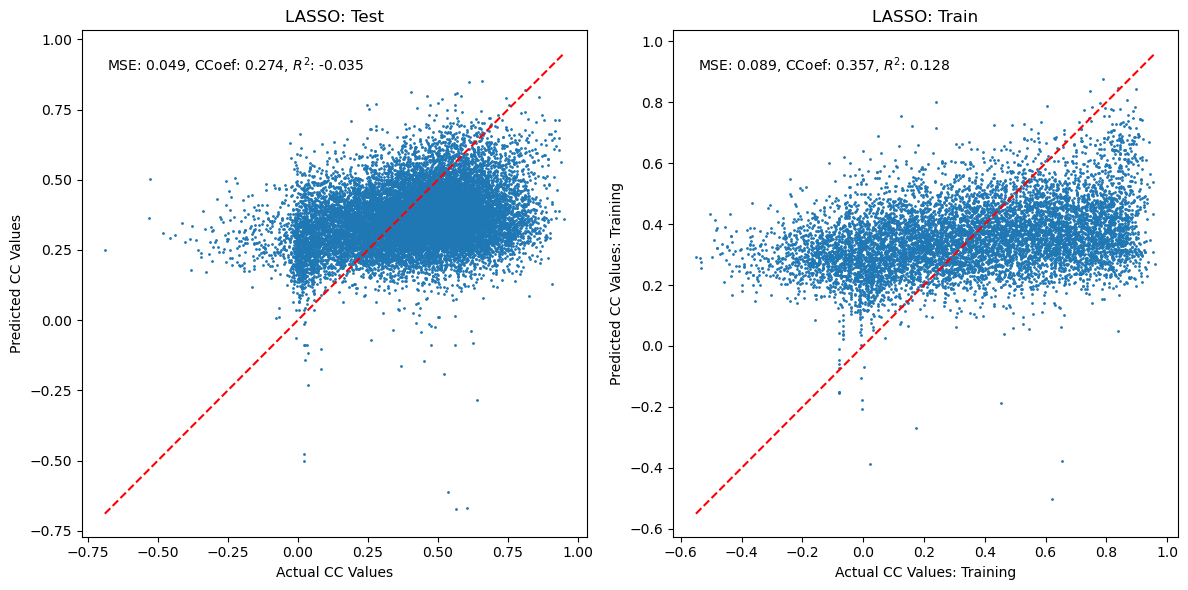

In [39]:
#init_alphas = np.array([0.23, 0.21, 0.19, 0.17, 0.15, 0.13, 0.1, 0.08, 0.05, 0.03, 1e-2, 1e-3, 1e-4])
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

############## Training & Testing using LASSOCV directly on original features ##############
target_density = 250; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
axs = axs.flatten()

############################ Trim Training Data ############################ 
trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
original_indices_train = []
y_train_trim = []
    
for it in range(trimmed_cc_train['original_index'].shape[0]):
    original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
    y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
original_indices_train = np.array(original_indices_train)
y_train_trim = np.array(y_train_trim)
X_train_trim = X_train[original_indices_train, :]
X_train_trim = scaler.fit_transform(X_train_trim)
    
# Least Absolute Shrinkage and Selection Operator (LASSO)
pipe = Pipeline([
                ('scaler', 
                 #StandardScaler()
                 MinMaxScaler()
                ), 
                ('lassocv', LassoCV(cv=5, 
                                    #alphas=init_alphas, 
                                    max_iter=1000000, tol=1e-4, selection='random', n_jobs=-1))
                ])
pipe.fit(X_train_trim, y_train_trim)

alphas = pipe.named_steps['lassocv'].alphas_ # Get the alphas from the LassoCV object
best_alpha = pipe.named_steps['lassocv'].alpha_ # Get the best alpha from the LassoCV object
#print(f"Best alpha: {best_alpha}, alphas: {alphas}")

X_test = scaler.transform(X_test)
y_pred_lasso = pipe.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_lasso) # Mean-Squared Error
r2_test = r2_score(y_test, y_pred_lasso) # R^2
correlation_matrix = np.corrcoef(y_test, y_pred_lasso)

################### Which features are considered "important" by LASSO ###################
coefficients = pipe.named_steps['lassocv'].coef_
# Identify non-zero coefficients (features to keep)
non_zero_indices = np.where(coefficients != 0)[0]
print(f"{non_zero_indices.size} Non-Zero PCs/Features Selected by LassoCV: {non_zero_indices}")
corr_coeff = correlation_matrix[0, 1]
axs[0].scatter(y_test, y_pred_lasso, s = 1)
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Best fit line 
axs[0].set_xlabel('Actual CC Values')
axs[0].set_ylabel('Predicted CC Values')
axs[0].set_title(f'LASSO: Test')
axs[0].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}, $R^2$: {r2_test:.3f}', 
            transform=axs[0].transAxes, 
            verticalalignment='top',
            horizontalalignment='left')

y_pred_lasso_train = pipe.predict(X_train_trim)
mse_train = mean_squared_error(y_train_trim, y_pred_lasso_train)
r2_train = r2_score(y_train_trim, y_pred_lasso_train) # R^2
correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
corr_coeff = correlation_matrix[0, 1]
axs[1].scatter(y_train_trim, y_pred_lasso_train, s = 1)
axs[1].plot([y_train_trim.min(), y_train_trim.max()], [y_train_trim.min(), y_train_trim.max()], 'r--') # Best fit line 
axs[1].set_xlabel('Actual CC Values: Training')
axs[1].set_ylabel('Predicted CC Values: Training')
axs[1].set_title(f'LASSO: Train')
axs[1].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}, $R^2$: {r2_train:.3f}',
            transform=axs[1].transAxes, 
            verticalalignment='top',
            horizontalalignment='left')
plt.tight_layout()
#plt.savefig(f'lassoTrainTrimData_A2_1_trajl{trajl}_vae{num_latent_dim}.png', dpi = 400, bbox_inches='tight')
plt.show()

In [ ]:
def unique_predictive_features(n_top_cont_features = 5):
    loadings = pca.components_
    feature_inds = np.array([]).astype(int)
    for i, pc in enumerate(loadings):
        # Gets indices of the top features for each PC
        top_features_indices = np.argsort(np.abs(pc))[-n_top_cont_features:] 
        #print(f"Top {n_cf} contributing feature indices for PC{i+1}: {top_features_indices}")
        feature_inds = np.append(feature_inds, top_features_indices)
    unique_feature_inds = np.unique(feature_inds)

    return unique_feature_inds

In [ ]:
target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for i, fov in enumerate(fovs_indc):
    test_fov = fov
    train_fovs = np.setdiff1d(fovs_indc, test_fov)
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    ############################ Trim Training Data ############################ 
    trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
    original_indices_train = []
    y_train_trim = []
    
    for it in range(trimmed_cc_train['original_index'].shape[0]):
        original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
        y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
    original_indices_train = np.array(original_indices_train)
    y_train_trim = np.array(y_train_trim)
    X_train_trim = X_train[original_indices_train, :]
    dim_reduction = False
    if dim_reduction:
        ############### Dimensional reduction on trimmed training data ###############
        pca.fit(X_train_trim) 
        Xpca_train_trim = pca.transform(X_train_trim)
        Xpca_test = pca.transform(X_test)
    else: 
        # Select features accroding to their predictive performance 
        top_contFeat_pc = 2 # Number of top contributing features in each PC
        #indc_predictive_features = unique_predictive_features(n_top_cont_features = top_contFeat_pc)
        indc_predictive_features = np.array([25, 31, 36, 42, 43, 55, 62, 77, 78, 92, 93, 94]).astype(int)
        print(f"Indices of top predictive features: {indc_predictive_features}") if i == 0 else None
        Xpca_train_trim = X_train_trim[:, indc_predictive_features]
        Xpca_test = X_test[:, indc_predictive_features]
    
    # Least Absolute Shrinkage and Selection Operator (LASSO)
    pipe = Pipeline([
                    ('scaler', StandardScaler()), 
                    ('lassocv', LassoCV(cv=100, max_iter=100000, tol=1e-5, selection='random', n_jobs=-1))
                    ])
    pipe.fit(Xpca_train_trim, y_train_trim)
    """
    y_pred_lasso = pipe.predict(Xpca_test)
    mse_test = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    """
    y_pred_lasso_train = pipe.predict(Xpca_train_trim)
    mse_train = mean_squared_error(y_train_trim, y_pred_lasso_train)
    correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
    
    ################### Which features are considered "important" by LASSO ###################
    coefficients = pipe.named_steps['lassocv'].coef_
    # Identify non-zero coefficients (features to keep)
    non_zero_indices = np.where(coefficients != 0)[0]
    print(f"Indices of Non-Zero PCs/Features Selected by LassoCV: {non_zero_indices}")
    corr_coeff = correlation_matrix[0, 1]
    #axs[i].scatter(y_test, y_pred_lasso, s = 1)
    axs[i].scatter(y_train_trim, y_pred_lasso_train, s = 1)
    axs[i].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    #axs[i].set_xlabel('Actual CC Values')
    #axs[i].set_ylabel('Predicted CC Values')
    axs[i].set_xlabel('Actual CC Values: Training')
    axs[i].set_ylabel('Predicted CC Values: Training')
    axs[i].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    axs[i].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}',
    #axs[i].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}', 
                transform=axs[i].transAxes, 
                verticalalignment='top',
                horizontalalignment='left')
plt.tight_layout()
#plt.show()
plt.savefig(f'lassoTrainTrimTestTrainDataSupFeat4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')
#plt.savefig(f'lassoTrainTrimTestFullDataSupFeat4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')

Indices of top predictive features from LASSOCV on snapshots: [25 31 36 42 43 55 62 77 78 92 93 94]

In [ ]:
target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for i, fov in enumerate(fovs_indc):
    test_fov = fov
    train_fovs = np.setdiff1d(fovs_indc, test_fov)
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    ############## Trim Training Data ############## 
    trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
    original_indices_train = []
    y_train_trim = []
    
    for it in range(trimmed_cc_train['original_index'].shape[0]):
        original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
        y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
    original_indices_train = np.array(original_indices_train)
    y_train_trim = np.array(y_train_trim)
    X_train_trim = X_train[original_indices_train, :]
    dim_reduction = False
    if dim_reduction:
        ############### Dimensional reduction on trimmed training data ###############
        pca.fit(X_train_trim) 
        Xpca_train_trim = pca.transform(X_train_trim)
        Xpca_test = pca.transform(X_test)
    else: 
        # Select features accroding to their predictive performance 
        top_contFeat_pc = 2 # Number of top contributing features in each PC
        #indc_predictive_features = unique_predictive_features(n_top_cont_features = top_contFeat_pc)
        indc_predictive_features = np.array([25, 31, 36, 42, 43, 55, 62, 77, 78, 92, 93, 94]).astype(int)
        print(f"Indices of top predictive features: {indc_predictive_features}") if i == 0 else None
        Xpca_train_trim = X_train_trim[:, indc_predictive_features]
        Xpca_test = X_test[:, indc_predictive_features]
    
    # Least Absolute Shrinkage and Selection Operator (LASSO)
    pipe = Pipeline([
                    ('scaler', StandardScaler()), 
                    ('lassocv', LassoCV(cv=100, max_iter=100000, tol=1e-5, selection='random', n_jobs=-1))
                    ])
    pipe.fit(Xpca_train_trim, y_train_trim)
    
    y_pred_lasso = pipe.predict(Xpca_test)
    mse_test = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    """
    y_pred_lasso_train = pipe.predict(Xpca_train_trim)
    mse_train = mean_squared_error(y_train_trim, y_pred_lasso_train)
    correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
    """
    ################### Which features are considered "important" by LASSO ###################
    coefficients = pipe.named_steps['lassocv'].coef_
    # Identify non-zero coefficients (features to keep)
    non_zero_indices = np.where(coefficients != 0)[0]
    print(f"Indices of Non-Zero PCs/Features Selected by LassoCV: {non_zero_indices}")
    
    corr_coeff = correlation_matrix[0, 1]
    xy = np.vstack([y_test, y_pred_lasso])
    #xy = np.vstack([y_train_trim, y_pred_lasso_train])
    z = scipy.stats.gaussian_kde(xy)(xy)
    
    sc = axs[i].scatter(y_test, y_pred_lasso, c=z, s=1, label='Data Points')
    axs[i].tricontour(y_test, y_pred_lasso, z, levels=14, linewidths=0.5, colors='k')
    contour_plot = axs[i].tricontourf(y_test, y_pred_lasso, z, levels=14, cmap="RdBu_r")
    """
    sc = axs[i].scatter(y_train_trim, y_pred_lasso_train, c=z, s=1, label='Data Points')
    axs[i].tricontour(y_train_trim, y_pred_lasso_train, z, levels=14, linewidths=0.5, colors='k')
    contour_plot = axs[i].tricontourf(y_train_trim, y_pred_lasso_train, z, levels=14, cmap="RdBu_r")
    """
    # Add a colorbar to each subplot
    fig.colorbar(contour_plot, ax=axs[i], label='Density')
    axs[i].set_xlabel('Actual CC Values')
    axs[i].set_ylabel('Predicted CC Values')
    #axs[i].set_xlabel('Actual CC Values: Training')
    #axs[i].set_ylabel('Predicted CC Values: Training')
    axs[i].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    #axs[i].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}',
    axs[i].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}', 
                transform=axs[i].transAxes, 
                verticalalignment='top',
                horizontalalignment='left')
plt.tight_layout()
#plt.show()
#plt.savefig(f'lassoTrainTrimTestTrimDataSupFeat4FOVsContour_trajl{trajl}.png', dpi = 400, bbox_inches='tight')
plt.savefig(f'lassoTrainTrimTestFullDataSupFeat4FOVsContour_trajl{trajl}.png', dpi = 400, bbox_inches='tight')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, Dense, Input, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
num_features = 10
pca_nn = PCA(n_components = num_features)

In [ ]:
dim_reduction = False
if dim_reduction:
    ############### Dimensional reduction on trimmed training data ###############
    pca_nn.fit(X_train_trim) 
    Xpca_train_nn = pca_nn.transform(X_train_trim)
    Xpca_test_nn = pca_nn.transform(X_test)
else: 
    # Select features accroding to their predictive performance 
    top_contFeat_pc = 2 # Number of top contributing features in each PC
    #indc_predictive_features = unique_predictive_features(n_top_cont_features = top_contFeat_pc)
    indc_predictive_features = np.array([25, 31, 36, 42, 43, 55, 62, 77, 78, 92, 93, 94]).astype(int)
    print(f"Indices of top predictive features: {indc_predictive_features}") if i == 0 else None
    Xpca_train_nn = X_train_trim[:, indc_predictive_features]
    Xpca_test_nn = X_test[:, indc_predictive_features]

In [ ]:
scaler = StandardScaler() # Scale features
Xnn_train_scaled = scaler.fit_transform(Xpca_train_nn)
Xnn_test_scaled = scaler.transform(Xpca_test_nn)

In [ ]:
# Define class boundaries
def class_conditions(data, c1, c2):
    conditions = [ data < c1, # Class 1: CC values depicting G2 cell cycle state
                  (data >= c1) & (data < c2), # Class 2: CC values depicting mixed cell-cycle states 
                  data >= c2 # Class 3: CC values > the median, depicting G1 cell cycle state  
                 ]
    return conditions

In [ ]:
# Define class labels for each condition
choices = [0, 1, 2]  # Class labels
c1 = 0.0; c2 = 0.85
# Apply classification on training & test data
y_train_class = np.select(class_conditions(y_train_trim, c1, c2), choices)
y_test_class = np.select(class_conditions(y_test, c1, c2), choices)

# Convert labels to one-hot encoding
y_train_class_onehot = to_categorical(y_train_class)
y_test_class_onehot = to_categorical(y_test_class)

In [ ]:
num_features = indc_predictive_features.size
# Define the Neural Network model architecture
model_nn = Sequential([Input(shape=(num_features, )),  # Input shape for the model (feature vector)
                       Reshape((num_features, 1, 1)),  # Reshape to fit Conv2D layer requirements
                       Conv2D(32, kernel_size=(3, 1), padding='same'), # First CNN layer
                       LeakyReLU(),
                       MaxPooling2D(pool_size=(2, 1)),
                       Dropout(0.2),
                       Conv2D(64, kernel_size=(3, 1), padding='same'), # Second CNN layer
                       LeakyReLU(),
                       MaxPooling2D(pool_size=(2, 1)),
                       Dropout(0.2),
                       Conv2D(128, kernel_size=(3, 1), padding='same', kernel_regularizer=l2(0.01)), # Third CNN layer
                       LeakyReLU(),
                       MaxPooling2D(pool_size=(2, 1)),
                       Dropout(0.2),
                       Flatten(), # Flatten the output of the last CNN layer to feed into a dense layer
                       Dense(256, kernel_regularizer = l2(0.01)),
                       LeakyReLU(),
                       Dropout(0.2),
                       Dense(128),
                       LeakyReLU(),
                       Dropout(0.2),
                       Dense(64, kernel_regularizer = l2(0.01)),
                       LeakyReLU(),
                       Dropout(0.2),
                       Dense(32),
                       LeakyReLU(),
                       Dropout(0.2),
                       Dense(3, activation='softmax')  # Output layer for 3 classes
                       ])
# Compile the model
model_nn.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
# Add early stopping to overcome overfitting 
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=15,
                               restore_best_weights=True)

In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Train the model
history_nn = model_nn.fit(Xnn_train_scaled,
                    y_train_class_onehot,
                    epochs=50,
                    batch_size=10, 
                    validation_split=0.2,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

In [ ]:
#model_nn.save('nn_model.keras') # Save the model
# Predict on the test sets
y_pred_nn = model_nn.predict(Xnn_test_scaled)

In [ ]:
predicted_classes = np.argmax(y_pred_nn, axis=1)
accuracy = accuracy_score(y_test_class, predicted_classes) # Calculate the accuracy of the predictions
print("Accuracy:", accuracy)

In [ ]:
conf_matrix = confusion_matrix(y_test_class, predicted_classes) # Calculate confusion matrix
# Row-normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]

In [ ]:
plt.clf()
plt.figure(figsize = (7, 6))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix: Predicted vs Actual CC values of Test Set')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.tight_layout()
plt.show()
#plt.savefig('confMatTestPred1B_train3A.png', dpi = 400, bbox_inches='tight')

In [ ]:
plt.clf()
plt.figure(figsize = (9, 5))
plt.subplot(1, 2, 1)
plt.plot(history_nn.history['accuracy'])
plt.plot(history_nn.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_nn.history['loss'])
plt.plot(history_nn.history['val_loss'])
plt.title('Model loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
predictions = y_pred_nn[:, 2]
plt.clf()
plt.figure(figsize=(7, 5))
plt.scatter(y_test, predictions, color='blue', s=1) 
plt.scatter(y_test, y_pred_nn[:, 0], color='red', s=1) 
plt.scatter(y_test, y_pred_nn[:, 1], color='cyan', s=1) 
plt.title('Actual vs. Predicted CC Values: DNN')
plt.xlabel('Actual CC Values')
plt.ylabel('Predicted CC Values')

# Plot a line of perfect prediction
min_val = min(min(y_test), min(predictions))
max_val = max(max(y_test), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.grid(True)
plt.show()

In [ ]:
model_linReg = LinearRegression(n_jobs=-1) # Simple Linear Regression
# Linear Regressor with Stochastic Gradient Descent 
model_lrSGD = SGDRegressor(max_iter=10000, tol=1e-4, learning_rate='invscaling', eta0=0.01)